In [1]:
import os
import pandas as pd 
import numpy as np
from multiprocessing import Pool 
import multiprocessing
from data_loader import data_loader #data_loader.py 파일을 다운 받아 주셔야 합니다. 
from tqdm import tqdm
from functools import partial

import matplotlib.pyplot as plt
from collections import Counter

import glob


In [2]:
def data_loader_all(func, path, train, nrows, **kwargs):
    '''
    Parameters:
    
    func: 하나의 csv파일을 읽는 함수 
    path: [str] train용 또는 test용 csv 파일들이 저장되어 있는 폴더 
    train: [boolean] train용 파일들 불러올 시 True, 아니면 False
    nrows: [int] csv 파일에서 불러올 상위 n개의 row 
    lookup_table: [pd.DataFrame] train_label.csv 파일을 저장한 변수 
    event_time: [int] 상태_B 발생 시간 
    normal: [int] 상태_A의 라벨
    
    Return:
    
    combined_df: 병합된 train 또는 test data
    '''
    
    # 읽어올 파일들만 경로 저장 해놓기 
    files_in_dir = os.listdir(path)
    
    files_path = [path+'/'+file for file in files_in_dir]
    
    if train :
        func_fixed = partial(func, nrows = nrows, train = True, lookup_table = kwargs['lookup_table'], event_time = kwargs['event_time'], normal = kwargs['normal'])
        
    else : 
        func_fixed = partial(func, nrows = nrows, train = False)
    
    
    # 여러개의 코어를 활용하여 데이터 읽기 
    if __name__ == '__main__':
        pool = Pool(processes = multiprocessing.cpu_count()) 
        df_list = list(tqdm(pool.imap(func_fixed, files_path), total = len(files_path)))
        pool.close()
        pool.join()
    
    # 데이터 병합하기 
    combined_df = pd.concat(df_list, ignore_index=True)
    
    return combined_df
    

In [3]:
# nrows를 50으로 진행 600하면 터짐. 높이면 성능 올라갈듯. 제너레이터 필요.

train_path = 'train'
test_path = 'test'
label = pd.read_csv('train_label.csv')
train = data_loader_all(data_loader, path = train_path, train = True, nrows = 100, normal = 999, event_time = 10, lookup_table = label)

100%|██████████| 827/827 [00:56<00:00, 14.56it/s]


In [4]:
# train.to_csv('./train_100.csv', index=False)

In [5]:
# train = pd.read_csv('./train_100.csv')

In [6]:
# test = data_loader_all(data_loader, path = test_path, train = False, nrows = 60)


## 위까지 데이콘 코드 아래부터 추가코드

In [7]:
train.shape

(82700, 5124)

(array([ 9., 12., 20., 10., 41., 19.,  9., 29.,  4., 20., 13.,  4.,  4.,
        19.,  4., 14.,  9., 32.,  5., 26., 10., 23., 10., 13.,  4.,  4.,
         4., 27., 74., 74., 22., 26., 28., 16.,  7.,  4.,  4.,  8.,  4.,
        12., 14., 16., 17., 18., 33., 34.,  4.,  4.,  7.,  4.]),
 array([  0.  ,   3.94,   7.88,  11.82,  15.76,  19.7 ,  23.64,  27.58,
         31.52,  35.46,  39.4 ,  43.34,  47.28,  51.22,  55.16,  59.1 ,
         63.04,  66.98,  70.92,  74.86,  78.8 ,  82.74,  86.68,  90.62,
         94.56,  98.5 , 102.44, 106.38, 110.32, 114.26, 118.2 , 122.14,
        126.08, 130.02, 133.96, 137.9 , 141.84, 145.78, 149.72, 153.66,
        157.6 , 161.54, 165.48, 169.42, 173.36, 177.3 , 181.24, 185.18,
        189.12, 193.06, 197.  ]),
 <a list of 50 Patch objects>)

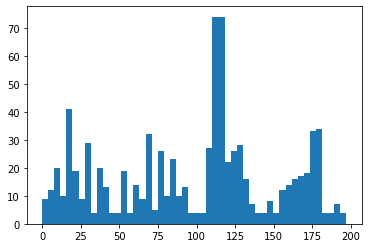

In [8]:
#라벨분포. 라벨 분포에 따라 적은 라벨은 학습이 덜될수도 있을듯?
#업샘플링, 다운샘플링 연구 필요
plt.hist(label.label, bins=50)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier


In [10]:
#랜덤포레스트 분류기 사용해서 진행.
#더 좋은 모델 사용하면 오를듯.
#999는 '상태A'임. 다빼버림.

rfc = RandomForestClassifier()

train_X = train[train.label!=999]
train_y = train_X.label

train_X = train_X.drop(['id','time','label'], axis=1)

In [11]:
train_X.shape, train_y.shape

((74430, 5121), (74430,))

In [12]:
#학습

rfc.fit(train_X,train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [13]:
# test csv 들을 넣어서 각csv의 row별로 라벨 별 확률값인 predict_proba를 평균내서 각 csv별 predict_proba를 구함.
# 1154, 1168은 문자열포함이라 추론에러남. 그냥 빼고 진행. 나중에 0으로 채움.

results = []

for i in range(828,1548):
    print(i)
    if i != 1154 and i != 1168:
        tmp = pd.read_csv('./test/'+str(i)+'.csv')
        tmp = tmp.drop(['time'], axis=1)
        result = rfc.predict_proba(tmp)

        results.append(np.mean(result,axis=0))

828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
10

In [14]:
#위에서 뺀 1154, 1168자리에 0으로 채움

results.insert(326,[0]*198)
results.insert(340,[0]*198)

In [15]:
#id열 추가하고 DF만듬.

id = pd.DataFrame(np.arange(828,1548), columns=['id'])
submit = pd.DataFrame(results)

submit = pd.concat([id,submit], axis=1)

In [16]:
submit.head()

,id,0,1,2,3,4,5,6,7,8,...,188,189,190,191,192,193,194,195,196,197
0,828,0.000333,0.000333,0.0000,0.000167,0.001000,0.002000,0.000000,0.000500,0.002667,...,0.001000,0.003000,0.001667,0.003167,0.001167,0.002167,0.001167,0.001667,0.000167,0.001333
1,829,0.000000,0.000000,0.0000,0.000167,0.001000,0.001833,0.000167,0.000167,0.004333,...,0.001000,0.001833,0.001167,0.002833,0.001833,0.002667,0.001833,0.001333,0.000000,0.001000
2,830,0.000000,0.000000,0.0000,0.000000,0.001000,0.002333,0.000167,0.000500,0.002667,...,0.000333,0.001833,0.000833,0.003000,0.002500,0.001667,0.000500,0.001000,0.000167,0.001667
3,831,0.000167,0.000000,0.0000,0.000000,0.046167,0.046833,0.074333,0.065333,0.013500,...,0.001333,0.003500,0.000500,0.004000,0.003167,0.002833,0.002500,0.001167,0.000000,0.001500
4,832,0.002667,0.001500,0.0025,0.001833,0.005167,0.003500,0.002833,0.003500,0.000833,...,0.000000,0.001333,0.000500,0.001000,0.000000,0.000667,0.000167,0.000667,0.001333,0.000167


In [17]:
submit.shape


(720, 199)

In [18]:
#id 1154에 0들어갔는지 확인

submit[submit['id']==1154]

,id,0,1,2,3,4,5,6,7,8,...,188,189,190,191,192,193,194,195,196,197
326,1154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
#id 1154에 0들어갔는지 확인

submit[submit['id']==1168]

,id,0,1,2,3,4,5,6,7,8,...,188,189,190,191,192,193,194,195,196,197
340,1168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
#데이터프레임 생성

submit.to_csv('./submit_test.csv', index=False)